# Example : Solving Matrix with Bidirectional HASVD

In this notebook, we have examples of solving matrices with a two-level bidirectional HASVD.

## TOC:
1. [General matrix](#first-bullet)
2. [Hankel matrix](#second-bullet)

In [2]:
import numpy as np     # We always need NumPy :)

## 1. General matrix <a class="anchor" id="first-bullet"></a>

We start of by generating a general matrix as well as pre-partition it.

In [3]:
from hasvd.utils.matrix import random_matrix

seed = 42               # RNG seed

M = 4                  # Num. of row blocks
N = 4                  # Num. of column blocks
(m,n) = (600,700)      # Block size
r = 10                  # Desired rank

matrix_rng=np.random.Generator(np.random.MT19937(seed))

A = random_matrix(M*m,M*n,r=r,rng=matrix_rng,method="qr")

print("Generated random general matrix...")
print("Prescribed rank:", r)
print("Matrix rank sanity check:", np.linalg.matrix_rank(A))
print("Matrix shape:", A.shape)
print("Block shape:", "(", m, ",", n, ")")
print("Block partitions:", "(", M, ",", N, ")\n")

Generated random general matrix...
Prescribed rank: 10
Matrix rank sanity check: 10
Matrix shape: (2400, 2800)
Block shape: ( 600 , 700 )
Block partitions: ( 4 , 4 )



Lets start computing. We prescribe a tolerance, control parameter here. 

In [4]:
tol = 1e-8
omega = 0.1

We also have a `svd_with_tol` which is basically `np.linalg.svd` with tolerances prescribed.

In [5]:
from hasvd.utils.svd import svd_with_tol
from time import time

print("\u0332".join("LAPACK gesdd"))
# SVD of the whole matrix
start = time()
U, E, Vh = svd_with_tol(
    A,
    full_matrices=False,
    truncate_tol=tol,
)
duration = time()-start
print("Error:", np.linalg.norm(A - U @ np.diag(E) @ Vh))
print("Runtime:", duration," seconds")
print("Rank of U*S*Vt:", np.linalg.matrix_rank(U @ np.diag(E) @ Vh), "\n")

L̲A̲P̲A̲C̲K̲ ̲g̲e̲s̲d̲d
Error: 2.703827784753225e-15
Runtime: 12.367504358291626  seconds
Rank of U*S*Vt: 10 



Lets now do HASVD. We start with creating a tree using routines in the `hasvd.utils.trees`. We here should define the direction of aggregation as well.

This will generate a `hasvd_Node` object, which defines a tree. From this you can construct any tree. To check that the aggregation shape of your tree is consistent, use the `assert_shape_consistency` method.

In [6]:
from hasvd.utils.trees import tlbd_dist_hasvd_tree, tlbd_inc_hasvd_tree, assert_shape_consistency

outer_direction = 1     # Direction of the root-level aggregation
tree_choice = 1         # Choice of tree: 0 distributed, 1 incremental

match outer_direction:
    case 0:
        num_outer_slices=N
        num_inner_slices=M
    case 1:
        num_outer_slices=M
        num_inner_slices=N

trees = [tlbd_dist_hasvd_tree(num_outer_slices,num_inner_slices,outer_direction,(m,n)),tlbd_inc_hasvd_tree(num_outer_slices,num_inner_slices,outer_direction,(m,n))]

for tree in trees:
    assert_shape_consistency(tree)

tree = trees[tree_choice]
print(tree) # Print to check shape of tree if necessary.

r r [2400x2800]
+-c 17 [600x2800]
| +-l 0 [600x700]
| +-l 1 [600x700]
| +-l 2 [600x700]
| +-l 3 [600x700]
+-r 18 [1800x2800]
  +-c 19 [600x2800]
  | +-l 4 [600x700]
  | +-l 5 [600x700]
  | +-l 6 [600x700]
  | +-l 7 [600x700]
  +-r 20 [1200x2800]
    +-c 21 [600x2800]
    | +-l 8 [600x700]
    | +-l 9 [600x700]
    | +-l 10 [600x700]
    | +-l 11 [600x700]
    +-c 22 [600x2800]
      +-l 12 [600x700]
      +-l 13 [600x700]
      +-l 14 [600x700]
      +-l 15 [600x700]


We now build a block-to-leaf mapping to connect the matrix to the tree using our map generators in `hasvd.utils.trees`. 

We should also prescribe nodal errors. This is given in `hasvd.utils.errors`.

Then we can perform the HASVD using the `hasvd.utils.svd.hasvd`. In here we can also track ranks connected to a node by setting `track_ranks=True`.

In [7]:
from hasvd.utils.trees import tlbd_general_btl_map,branch_node_count, non_leaf_count
from hasvd.utils.errors import tight_error,naive_error

from hasvd.utils.svd import hasvd


btl_map = tlbd_general_btl_map(A,M,N,m,n,outer_direction)   # Makes a map to block of a node
error_choice = 0                                            # Choice of error_prescription: 0 naive, 1 tight

nodal_errors = [lambda node : tight_error(
            node,
            tol,
            omega,
            branch_node_count(tree),
        ),lambda node : naive_error(
            node,
            tol,
            omega,
            non_leaf_count(tree),
        )]
nodal_error=nodal_errors[error_choice]

print("\u0332".join("HASVD"))
# SVD of the whole matrix
start = time()
U, E, Vh, rank_dict = hasvd(tree,btl_map,nodal_error, track_ranks=True)
duration = time()-start
print("Error:", np.linalg.norm(A - U @ np.diag(E) @ Vh))
print("Runtime:", duration," seconds")
print("Rank of U*S*Vt:", np.linalg.matrix_rank(U @ np.diag(E) @ Vh), "\n")

H̲A̲S̲V̲D
Error: 9.030833402813129e-15
Runtime: 7.616787672042847  seconds
Rank of U*S*Vt: 10 



We can see the plot tree

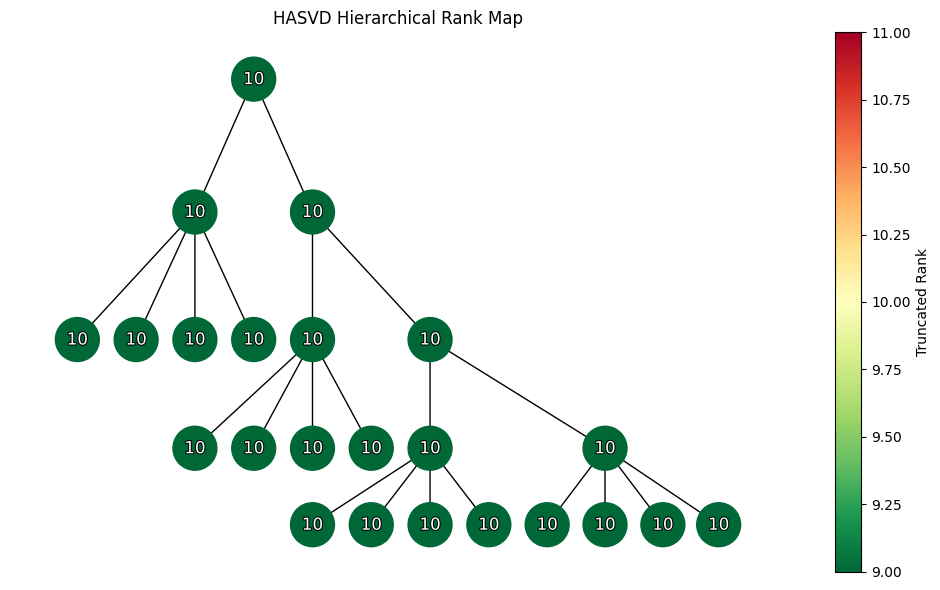

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.patheffects as path_effects

from hasvd.utils.trees import hasvd_Node

def plot_tree_graph(root:hasvd_Node, node_rank_map, cmap='RdYlGn_r'):
    G = nx.DiGraph()
    color_vals = []

    G.add_node(root)
    color_vals.append(node_rank_map.get(root, 0))
    
    for node in root.traverse():
        for child in node.children:
            G.add_node(child)
            G.add_edge(node, child)
            color_vals.append(node_rank_map.get(child, 0))

    
    # Generate the layout using graphviz_layout
    pos = nx.nx_agraph.graphviz_layout(
        G,
        prog="dot",
        args=f"-Groot={root.tag}",
    )
    
    # Create figure and axis manually
    fig, ax = plt.subplots(figsize=(10, 6))

    # Draw nodes and edges
    nx.draw_networkx_nodes(
        G,
        pos,
        node_color=color_vals,
        cmap=plt.get_cmap(cmap),
        ax=ax,
        node_size=1000
    )
    nx.draw_networkx_edges(G, pos, ax=ax)
    
    for node, (x, y) in pos.items():
        val = node_rank_map.get(node, 0)
        label = f"{val}"
        ax.text(
            x, y, label, fontsize=12, ha='center', va='center', color='white',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'),
                          path_effects.Normal()]
        )
    
    # Add colorbar manually with mappable
    sm = ScalarMappable(norm=Normalize(vmin=min(color_vals), vmax=max(color_vals)), cmap=cmap)
    sm.set_array([])  # Required for matplotlib >= 3.1
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Truncated Rank")

    ax.set_title("HASVD Hierarchical Rank Map")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_tree_graph(tree,rank_dict)

## 1. Hankel matrix <a class="anchor" id="second-bullet"></a>

We now go with Hankel. In this case we can construct sequence of Hankel elements or the matrix explicitly due to recursion. Due to memory purposes, we will use the sequence, just to demonstrate that we do not need to access the entire matrix to get a block in Hankel! Here we use `array_to_hankel` to do this.

In [9]:
# HANKEL MATRIX GENERATION

from hasvd.utils.matrix import array_to_hankel, fid_signal_sequence, lrf_sequence

seed = 42               # RNG seed

M = 4                  # Num. of row blocks
N = 4                  # Num. of column blocks
(m,n) = (600,700)      # Block size
r = 400                  # Desired rank

matrix_rng=np.random.Generator(np.random.MT19937(seed))

A_array = lrf_sequence(r,M*m+N*n-1,matrix_rng)

A = array_to_hankel(A_array,(M*m,N*n))

print("Generated random general matrix...")
print("Prescribed rank:", r)
print("Matrix rank sanity check:", np.linalg.matrix_rank(A))
print("Matrix shape:", A.shape)
print("Block shape:", "(", m, ",", n, ")")
print("Block partitions:", "(", M, ",", N, ")\n")

Generated random general matrix...
Prescribed rank: 400
Matrix rank sanity check: 399
Matrix shape: (2400, 2800)
Block shape: ( 600 , 700 )
Block partitions: ( 4 , 4 )



The next steps follows the standard practice.

In [ ]:
# PARAMETERS

tol = 1e-8            # Prescribe tolerance and control parameter
omega = 0.1


# STANDARD SVD COMPARISON

from hasvd.utils.svd import svd_with_tol
from time import time

print("\u0332".join("LAPACK gesdd"))
# SVD of the whole matrix
start = time()
U, Etrue, Vh = svd_with_tol(
    A,
    full_matrices=False
    ,truncate_tol=tol
)
duration = time()-start
print("Error:", np.linalg.norm(A - U @ np.diag(Etrue) @ Vh))
print("Runtime:", duration," seconds")
print("Rank of U*S*Vt:", np.linalg.matrix_rank(U @ np.diag(Etrue) @ Vh), "\n")

# TREE CONSTRUCTION

from hasvd.utils.trees import tlbd_dist_hasvd_tree, tlbd_inc_hasvd_tree, assert_shape_consistency

outer_direction = 1     # Direction of the root-level aggregation
tree_choice = 0         # Choice of tree: 0 distributed, 1 incremental

match outer_direction:
    case 0:
        num_outer_slices=N
        num_inner_slices=M
    case 1:
        num_outer_slices=M
        num_inner_slices=N

trees = [tlbd_dist_hasvd_tree(num_outer_slices,num_inner_slices,outer_direction,(m,n)),tlbd_inc_hasvd_tree(num_outer_slices,num_inner_slices,outer_direction,(m,n))]

for tree in trees:
    assert_shape_consistency(tree)

tree = trees[tree_choice]
print(tree) # Print to check shape of tree if necessary.

L̲A̲P̲A̲C̲K̲ ̲g̲e̲s̲d̲d
Error: 3.372179166956125e-14
Runtime: 15.9112229347229  seconds
Rank of U*S*Vt: 399 

r r [2400x2800]
+-c 16 [600x2800]
| +-l 0 [600x700]
| +-l 1 [600x700]
| +-l 2 [600x700]
| +-l 3 [600x700]
+-c 17 [600x2800]
| +-l 4 [600x700]
| +-l 5 [600x700]
| +-l 6 [600x700]
| +-l 7 [600x700]
+-c 18 [600x2800]
| +-l 8 [600x700]
| +-l 9 [600x700]
| +-l 10 [600x700]
| +-l 11 [600x700]
+-c 19 [600x2800]
  +-l 12 [600x700]
  +-l 13 [600x700]
  +-l 14 [600x700]
  +-l 15 [600x700]


We now build a different block-to-leaf map to connect the Hankel arrays from blocks to the tree. 

In [11]:
from hasvd.utils.trees import tlbd_hankelarray_btl_map,branch_node_count, non_leaf_count
from hasvd.utils.errors import tight_error,naive_error

from hasvd.utils.svd import hasvd

btl_map = tlbd_hankelarray_btl_map(A_array,M,N,m,n,outer_direction)   # Makes a map to block of a node
error_choice = 0                                            # Choice of error_prescription: 0 naive, 1 tight

nodal_errors = [lambda node : tight_error(
            node,
            tol,
            omega,
            branch_node_count(tree),
        ),lambda node : naive_error(
            node,
            tol,
            omega,
            non_leaf_count(tree),
        )]
nodal_error=nodal_errors[error_choice]

print("\u0332".join("HASVD"))
start = time()
U, E, Vh, rank_dict = hasvd(tree,btl_map,nodal_error, track_ranks=True)
duration = time()-start
print("Error:", np.linalg.norm(A - U @ np.diag(E) @ Vh))
print("Runtime:", duration," seconds")
print("Rank of U*S*Vt:", np.linalg.matrix_rank(U @ np.diag(E) @ Vh), "\n")

H̲A̲S̲V̲D
Error: 4.727570702313038e-09
Runtime: 14.015357732772827  seconds
Rank of U*S*Vt: 546 



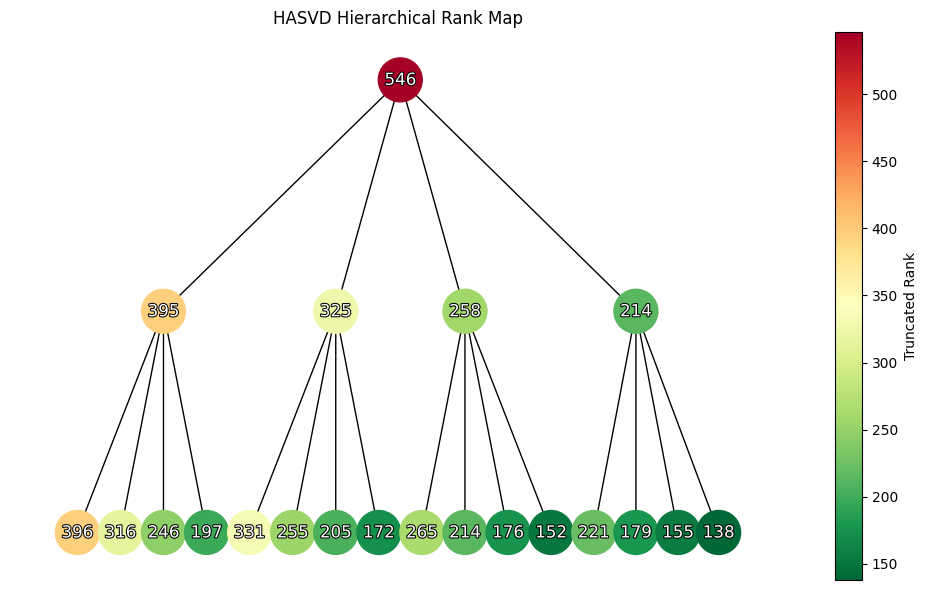

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.patheffects as path_effects

from hasvd.utils.trees import hasvd_Node

def plot_tree_graph(root:hasvd_Node, node_rank_map, cmap='RdYlGn_r'):
    G = nx.DiGraph()
    color_vals = []

    G.add_node(root)
    color_vals.append(node_rank_map.get(root, 0))
    
    for node in root.traverse():
        for child in node.children:
            G.add_node(child)
            G.add_edge(node, child)
            color_vals.append(node_rank_map.get(child, 0))

    
    # Generate the layout using graphviz_layout
    pos = nx.nx_agraph.graphviz_layout(
        G,
        prog="dot",
        args=f"-Groot={root.tag}",
    )
    
    # Create figure and axis manually
    fig, ax = plt.subplots(figsize=(10, 6))

    # Draw nodes and edges
    nx.draw_networkx_nodes(
        G,
        pos,
        node_color=color_vals,
        cmap=plt.get_cmap(cmap),
        ax=ax,
        node_size=1000
    )
    nx.draw_networkx_edges(G, pos, ax=ax)
    
    for node, (x, y) in pos.items():
        val = node_rank_map.get(node, 0)
        label = f"{val}"
        ax.text(
            x, y, label, fontsize=12, ha='center', va='center', color='white',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'),
                          path_effects.Normal()]
        )
    
    # Add colorbar manually with mappable
    sm = ScalarMappable(norm=Normalize(vmin=min(color_vals), vmax=max(color_vals)), cmap=cmap)
    sm.set_array([])  # Required for matplotlib >= 3.1
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Truncated Rank")

    ax.set_title("HASVD Hierarchical Rank Map")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_tree_graph(tree,rank_dict)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_20949/2719021784.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("$\sigma_i$")
/tmp/ipykernel_20949/2719021784.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.title("Tolerance $\epsilon*$= "+str(tol))


(0.0, 600.0)

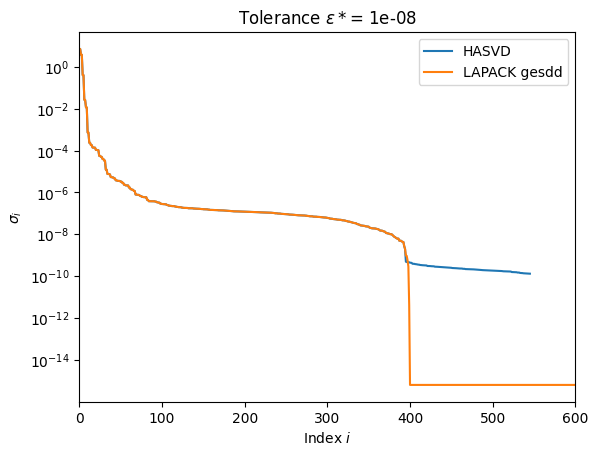

In [ ]:
fig=plt.figure()
plt.plot(E, label="HASVD")
plt.plot(Etrue, label="LAPACK gesdd")

plt.yscale('log')
plt.ylabel("$\sigma_i$")
plt.xlabel("Index $i$")
plt.title("Tolerance $\epsilon*$= "+str(tol))

plt.legend()

plt.xlim([0,600])